# Import librerie

In [1]:
import networkx as nx
from networkx.readwrite import json_graph
import random as rand
import json
import numpy as np

import matplotlib.pyplot as plt

import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as cm
import ndlib.models.compartments as cpm

# Classi di utilità
Definizione di un encoder numpy per serializzare i grafi in formato JSON per riutilizzo futuro.\
È stata realizzata per risolvere un problema sulla serializzazione dei grafi restituiti da networkx su alcuni tipi di dati.

In [2]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, ( np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

Classe per la creazione di grafi sintetici avanzata che combina più modelli generativi.

In [3]:
class AdvancedGraphCreator():
    def __init__(self,max_nodes,drop_prob):
        '''
        Args:
            max_nodes (int): massimo numero di nodi per il grafo da creare
            drop_prob (float): probabilità di eliminare casualmente un arco tra due nodi
        '''
        self.max_nodes = max_nodes
        self.drop_prob = drop_prob
    
    def generate_net(self,rounds,ratio,beta=0.01,rate=0.1,fraction_mis=0.01):
        '''
        Genera un grafo con etichette sui nodi che corrispondono all'etichetta del nodo e ad uno score (tra 0 e 1)
        sulla misinformatività del nodo.
        Args:
            rounds (int): numero di sottografi da generare per realizzare il grafo finale
            ratio (float): rapporto tra reti sintetiche generate con modello preferential attachment rispetto a quello small world
            beta (float): parametro di rewiring modello small-world
            rate (float): probablità di trasferimento misinformazione
            fraction_mis (float): frazione di nodi misinformativi iniziali sul totale
        Returns:
            G (Graph): il grafo generato con nodi etichettati 
        '''
        G = self._generate_graph_net_(rounds,ratio,beta)
        if len(G.nodes) == 0:
            return None
        if len(G.edges)==0:
            return None
        self._node_label_assignment_(G,rate,fraction_mis)
        if len([(u,v) for u,v in G.edges if G.nodes[u]['Misinformative']==1 or G.nodes[v]['Misinformative']==1]) == 0:
            return None
        self._sparsify_(G)
        self._edge_features_assignment_(G)
        self._edge_weight_(G)
        self._node_features_assignment_(G)
        return G
    
    def _generate_graph_net_(self,rounds,ratio,beta=0.01):
        '''
        Genera una rete sintetica ottenuta come combinazione di reti sintetiche diverse
        generate da modelli small world o preferential attachment.
        Args:
            rounds (int): numero di reti sintetiche che devono essere calcolate per realizzare la rete finale
            ratio (float): rapporto tra reti sintetiche generate con modello preferential attachment rispetto a quello small world
            beta (float): parametro di rewiring modello small-world
        Returns:
            G (Graph): grafo generato
        '''
        num_pref = int(rounds * ratio)-1
        n_sampler = lambda rounds: rand.randint(self.max_nodes//(2*rounds),self.max_nodes//rounds-1)
        n = n_sampler(rounds)
        G = nx.barabasi_albert_graph(n,rand.randint(n//4,n//2-1))
        for _ in range(num_pref):
            tmp = nx.barabasi_albert_graph(n,rand.randint(n//4,n//2-1))
            G = AdvancedGraphCreator._combine_graphs_(G,tmp,k=rand.randint(n//4,n//2-1))
        for _ in range(rounds - num_pref):
            tmp = nx.watts_strogatz_graph(n,rand.randint(n//4,n//2-1),beta)
            G = AdvancedGraphCreator._combine_graphs_(G,tmp,k=rand.randint(n//4,n//2-1))
        return G
    
    def _combine_graphs_(G1,G2,k,t=0.75):
        '''
        Combina i due grafi aggiungendo k nuovi archi tra coppie di nodi nei due grafi.
        Args:
            G1 (Graph): grafo sintetico
            G2 (Graph): grafo sintetico
            k (int): il numero di archi da aggiungere tra i due grafi
            t (float): probabilità che si crei un arco tra una coppia di nodi
        Returns:
            G (Graph): il grafo combinato
        '''
        max_g1_id = max(G1.nodes())
        pa_node_mapping = {old_id: new_id + max_g1_id + 1 for old_id, new_id in enumerate(G2.nodes())}
        G2 = nx.relabel_nodes(G2, pa_node_mapping)
        U = nx.union(G1,G2)
        c = 0
        while True:
            i = rand.randint(min(G1.nodes()),max(G1.nodes()))
            j = rand.randint(min(G2.nodes()),max(G2.nodes()))
            p = rand.uniform(0,1)
            if p > t and not U.has_edge(i,j):
                U.add_edge(i,j)
                c+=1
                if c == k:
                    break
        return U
    
    def _node_label_assignment_(self,G,rate,fraction_mis):
        '''
        Assegna le etichette ai nodi usando un modello di diffusione.
        Args:
            G (Graph): il grafo du cui etichettare i nodi
        '''
        G.nodes(data=True)
        status = self._simulate_diffusion_(G,rate,fraction_mis)
        for g in status.keys():
            if status[g] == 1:
                G.nodes[g]['Score'] = rand.uniform(0.65,1)
            else:
                G.nodes[g]['Score'] = rand.uniform(0,0.35)
            G.nodes[g]['Misinformative']=status[g]
   
    def _simulate_diffusion_(self,G,rate,fraction_mis,iters=10):
        '''
        Simula la diffusione della misinformation usando un modello Independent Cascade
        Args:
         G (Grapg): grafo su cui simulare il processo di diffusione
         iters (int): numero iterazioni processo di diffusione
         rate (float): probablità di trasferimento misinformazione
         fraction_mis (float): frazione di nodi misinformativi iniziali sul totale
        '''
        iter = rand.randint(iters//2,iters)
        model = cm.CompositeModel(G)
        # Model statuses
        model.add_status("Susceptible")
        model.add_status("Infected")

        # Compartment definition
        c1 = cpm.NodeStochastic(rate, triggering_status="Infected")

        # Rule definition
        model.add_rule("Susceptible", "Infected", c1)

        # Model initial status configuration
        config = mc.Configuration()
        config.add_model_parameter('fraction_infected', fraction_mis)

        # Simulation execution
        model.set_initial_status(config)
        model.iteration_bunch(iter)
        return model.status
   
    def _sparsify_(self,G):
        '''
        Elimina casualmente archi tra nodi misinformativi e non misinformativi. 
        Gli archi incidenti su nodi che hanno la stessa etichetta è più difficile che vengano rimossi.
        Args:
            G (Graph): un grafo Networkx
        '''
        for i,j in G.edges:
            if (G.nodes[i]['Misinformative'] != G.nodes[j]['Misinformative']):
                if rand.uniform(0,1)<=self.drop_prob:
                    G.remove_edge(i,j)
            else:
                if rand.uniform(0,1)<= self.drop_prob/2:
                    G.remove_edge(i,j)

    def _edge_features_assignment_(self,G,p=5,min=25,max=3000,k=15):
        '''
        Assegna agli archi (u,v) della rete un peso proporzionale al numero di individui nella stessa istanza che hanno
        interagito (interactions) con entrambi i post u e v.
        Args:
            G (Graph): il grafo su cui inserire i pesi sugli archi
            p (float): parametro della distribuzione (higer more skewed)
            k (float): esponente della trasformazione dei dati finali
            min (int): minimo numero di individui nella stessa istanza che hanno interagito sui post
            max (int): massimo numero individui nella stessa istanza che hanno interagito sui post
        '''

        misinform_edges = [(u,v) for u,v in G.edges if G.nodes[u]['Misinformative']==1 or G.nodes[v]['Misinformative']==1] # archi incidenti su un nodo misinformativo
        num_mis = len(misinform_edges)
        num_good = len(G.edges) - num_mis
        
        interactions_mis = AdvancedGraphCreator._sample_(p,num_mis,min,max,k)
        interactions_good = AdvancedGraphCreator._sample_(p/5,num_good,min,max,k=k/5)
        
        interactions = np.append(interactions_mis,interactions_good)
        interactions = np.array([interactions])

        mis_iter = np.nditer(np.array(interactions_mis))
        good_iter = np.nditer(np.array(interactions_good))
        for e in G.edges:
            i,j = e
            tmp = None
            if (G.nodes[i]['Misinformative']==1 or G.nodes[j]['Misinformative']==1):
                tmp = mis_iter.__next__()
            else:
                tmp = good_iter.__next__()
            G[i][j]['Interactions'] = tmp


    def _sample_(p,size,a,b,k):
        '''
        Campiona un numero prefissato (size) di elementi da una distribuzione con parametro p.
        Args:
            p (float): parametro della distribuzione
            size (int): numero di campioni da campionare
            a (int): valore minimimo per i dati campionati da restituire
            b (int): valore massimo per i dati campionati da restituire
            k (float): esponente della trasformazione dei dati finali (higer more skewed)
        Return:
            x (list[int]): campioni
        '''
        rng = np.random.default_rng()
        samples = rng.pareto(p, size)

        max = np.log(np.max(samples))
        min = np.log(np.min(samples))
        
        x = (np.log(samples)-min)/(max-min) +1e-3 #normalize in a range [0,1]
        x=a+(x**k)*(b-a) #apply transform
        return x.astype(int)
    
    def _edge_weight_(self,G):
        '''
        Assegna agli archi (u,v) della rete un peso proporzionale al numero di individui nella stessa istanza che hanno
        interagito (interactions) con entrambi i post u e v.
        Args:
            G (Graph): il grafo su cui inserire i pesi sugli archi
        '''
        processed_edges = set()

        for n in G.nodes():
            for u, v, data in G.edges(n, data=True):
                e = tuple(sorted((u,v)))
                if e not in processed_edges:
                    processed_edges.add(e)
                    u_interactions = sum(data['Interactions'] for _, _, data in G.edges(u, data=True))
                    v_interactions = sum(data['Interactions'] for _, _, data in G.edges(v, data=True))
                    
                    G[u][v]['Weight'] = ((G[u][v]['Interactions'] / u_interactions)+(G[u][v]['Interactions'] / v_interactions)) * 0.5
            s=0
            for u, v, _ in G.edges(n, data=True):
                s+= G[u][v]['Weight']

    def _node_features_assignment_(self,G):
        '''
        Assegna ai nodi della rete gli attributi per il numero di condivisioni e like ricevuti.
        Args:
            G (Graph): il grafo su cui aggiungere gli attributi
        '''
        for n in G.nodes:
            c = 0 #count for interactions
            for e in G.edges(n):
                i,j = e
                c+=G[i][j]['Interactions']

            s_n = 0.02 #portion factor for shares common range 0.5% - 2%
            c_n = 0.01 #portion factor for comments common range 0.5% - 1%
            l_n = 0.05 #portion factor for likes 2% - 10%
            d_n = 0.001225 #portion factor for dislikes 2% - 5% 

            if G.nodes[n]['Misinformative'] == 1:
                s_n = s_n / 2
                c_n = c_n / 2
                l_n = l_n / 2
                d_n = d_n ** 0.5

            G.nodes[n]['Visuals']=c
            G.nodes[n]['Shares']=rand.randint(int(c*(s_n/2)),int(c*s_n))
            G.nodes[n]['Comments']=rand.randint(int(c*(c_n/2)),int(c*c_n))
            G.nodes[n]['Likes']=rand.randint(int(c*(l_n/2)),int(c*l_n))
            G.nodes[n]['Dislikes']=rand.randint(int(c*(d_n/2)),int(c*(d_n)))

    def to_json(G):
        '''
        Restituisce la rapresentazione in formato JSON di un grafo.
        Args:
            G (Graph): il grafo per cui si vuole la rappresentazione JSON
        Returns:
            Json (str): rappresentazione JSON del grafo
        '''
        return  nx.node_link_data(G)
    
    def draw_graph_with_label(G):
        '''
        Disegna un grafo con etichette.
        Args:
            G (Graph): un grafo
        '''
        labels = {}
        for node, data in G.nodes(data=True):
            labels.update({node:data['Misinformative']})
        pos = nx.spring_layout(G)
        nx.draw(G,pos,with_labels=False)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')


# Metodi di utilità
Metodi che sevono a caricare e salvare i grafi sintetici.

In [4]:
def write_to_json(GS,path='out.json'):
    '''
        Scrivi sul file specificato i grafi.
        Args:
            GS (list[Graph]): i grafi da scrivere sul file
            path (str): percorso del file target
        '''
    data = []
    for g in GS:
        data.append(AdvancedGraphCreator.to_json(g))
    with open(path,'w') as file:
        json.dump(data, file, indent=4, sort_keys=True,separators=(', ', ': '), ensure_ascii=False,cls=NumpyEncoder)
        file.close()

# Generation of train data

In [5]:
gc = AdvancedGraphCreator(max_nodes=1500,drop_prob=0.75)
GS = []
k = 200
rounds = 25
for i in range(k):
    g = gc.generate_net(rounds,ratio=0.70)
    if g!=None:
        GS.append(g)
write_to_json(GS,path='advanced mixed train.json')

/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


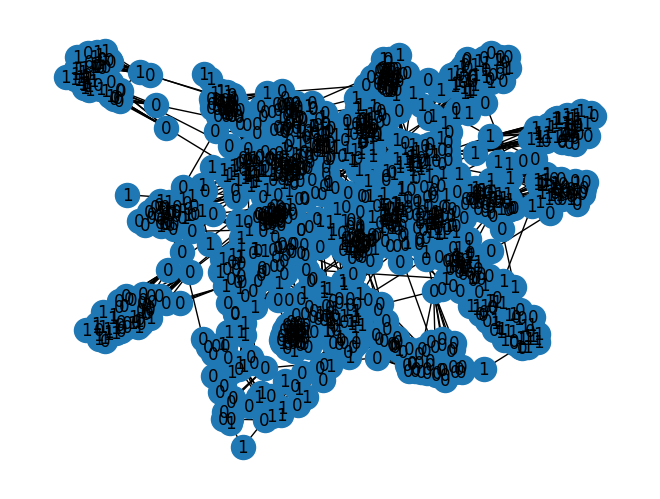

In [6]:
AdvancedGraphCreator.draw_graph_with_label(GS[0])

# Generation test data

In [7]:
gc = AdvancedGraphCreator(max_nodes=650,drop_prob=0.65)
GS = []
k = 30
rounds = 15
for i in range(k):
    g = gc.generate_net(rounds,ratio=0.55,beta=0.05,fraction_mis=0.05)
    if g!=None:
        GS.append(g)
write_to_json(GS,path='advanced mixed test.json')

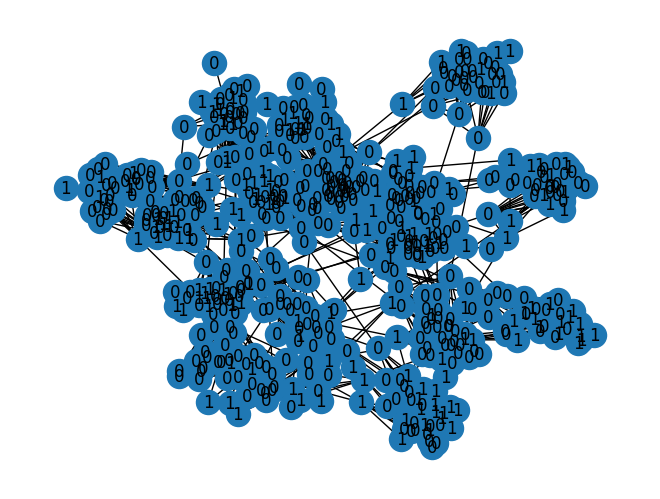

In [8]:
AdvancedGraphCreator.draw_graph_with_label(GS[1])